# Optic Disc Segmentation

In [51]:
%matplotlib inline

import os
import os.path
import cv2
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams['figure.dpi'] = 300

## Load the Images
Note to self: for consistency across platforms within my own repository structure, always run `jupyter notebook` from the root of this git repo `COMP9517`.

In [2]:
# repo_path = os.getcwd()
# data_path = os.path.join(repo_path, "assignments", "ass2", "Data_Individual_Component")

# retinal_images_path = os.path.join(data_path, "original_retinal_images")
# truth_masks_path = os.path.join(data_path, "optic_disc_segmentation_masks")

retinal_images_path = os.path.join("Data_Individual_Component", "original_retinal_images")
truth_masks_path = os.path.join("Data_Individual_Component", "optic_disc_segmentation_masks")

retinal_images_names = list(map(lambda x: os.path.join(retinal_images_path, x),os.listdir(retinal_images_path)))
truth_masks_names = list(map(lambda x: os.path.join(truth_masks_path, x), os.listdir(truth_masks_path)))

df = pd.DataFrame({"image_path": retinal_images_names, "mask_path": truth_masks_names})

## Read the image

In [ ]:
from skimage.morphology import extrema

img = cv2.imread(df.sample(1).iloc[0,:]["image_path"])

result = np.copy(img)

## Average Filter and Split into Channels

In [39]:
# apply average filter to reduce effect of noise
avg_filter_size = 50
avg_kernel = np.ones((avg_filter_size, avg_filter_size), np.float32) / avg_filter_size ** 2
result = cv2.filter2D(result, -1, avg_kernel)

b = result[:,:,0]
g = result[:,:,1]
r = result[:,:,2]

## Contrast Stretching

In [107]:
# perform contrast stretching
def contrast_stretch(x):
    inmax = 140
    if x >= inmax:
        return 255
    
    if x < 10:
        return 0

    return int(x * 255/inmax)

stretched = np.array([[contrast_stretch(pixel) for pixel in row] for row in g], dtype=np.uint8)

print(stretched, stretched.dtype)
print(g, g.dtype)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] uint8
[[2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]] uint8


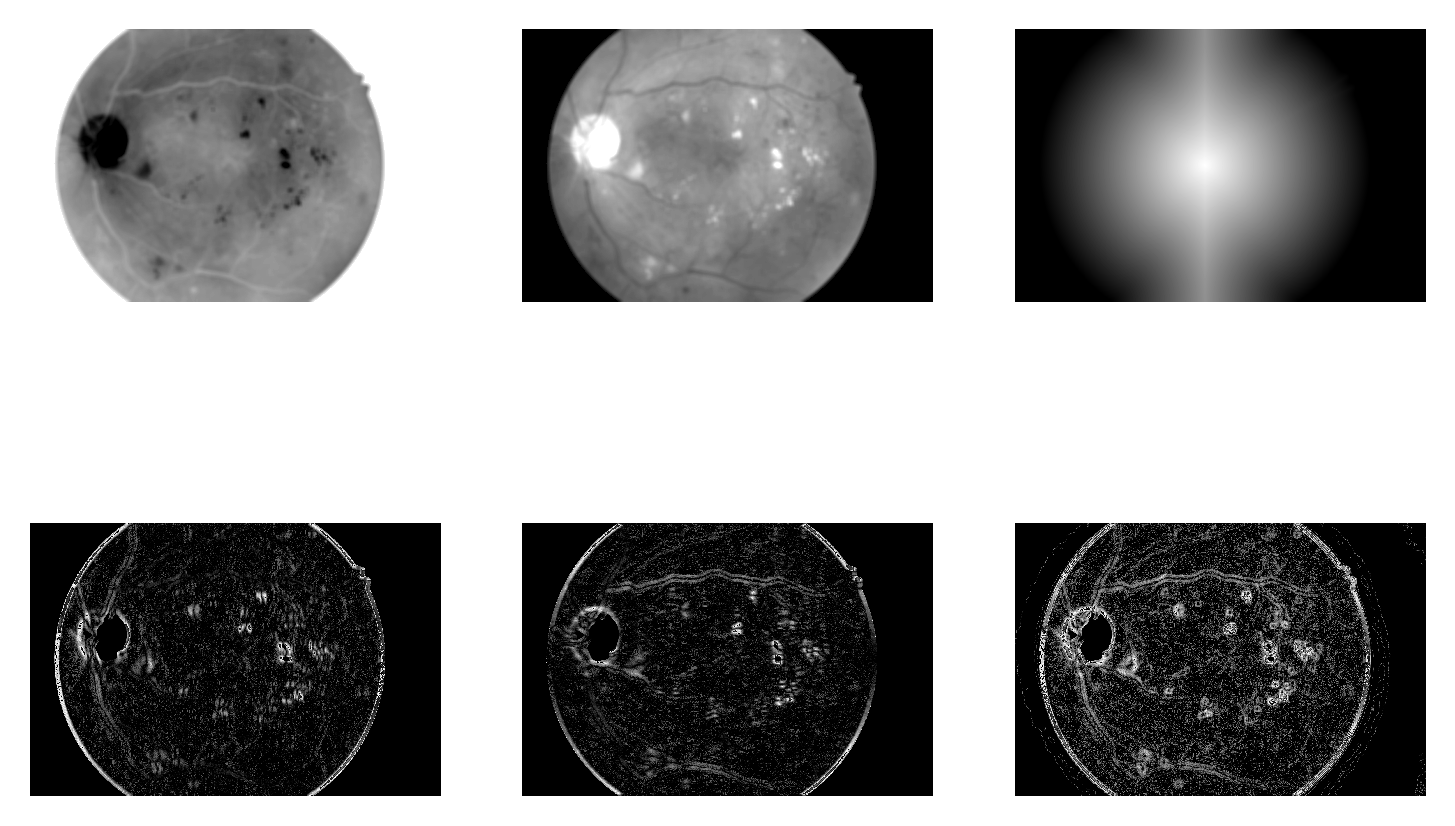

In [108]:
from scipy import ndimage as ndi


stretched_inverted = (np.ones(stretched.shape, dtype=np.uint8) * 255) - stretched

sobel_x = cv2.Sobel(stretched_inverted, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(stretched_inverted, cv2.CV_64F, 0, 1, ksize=5)

sobel_x = np.absolute(sobel_x)
sobel_x = np.uint8(sobel_x)

sobel_y = np.absolute(sobel_y)
sobel_y = np.uint8(sobel_y)

fig, axes = plt.subplots(2,3)

dist = ndi.distance_transform_edt(stretched)


for axe in axes:
    for ax in axe:
        ax.axis('off')


axes[0,0].imshow(stretched_inverted, cmap='gray', vmin=0, vmax=255)
axes[0,1].imshow(stretched, cmap='gray', vmin=0, vmax=255)
axes[0,2].imshow(dist, cmap='gray')

axes[1,0].imshow(sobel_x, cmap='gray')
axes[1,1].imshow(sobel_y, cmap='gray')
axes[1,2].imshow(gradient , cmap='gray')

In [77]:
np.where(sobel_x != 0)
print(sobel_x[0,672])
sobel_x.shape

8


(2848, 4288)

# Testing

In [37]:
def test_segmentation(image_path, truth_path):

    retinal_img = cv2.imread(image_path)
    truth_img = cv2.imread(truth_path)

    retinal_img = cv2.resize(retinal_img, None, fx=1, fy=1)

    segmented_img, max_diff_loc = segment(retinal_img)

    fig, axes = plt.subplots(1, 3)
    
    for ax in axes:
        ax.axis('off')
    
    axes[0].imshow(retinal_img)
    axes[1].imshow(truth_img)
    axes[2].imshow(segmented_img)
    
    pass

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] uint8
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] uint8
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


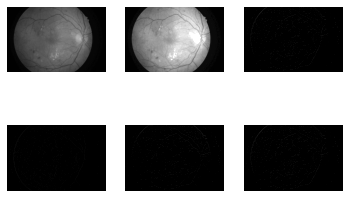

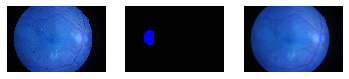

In [38]:
data = df.sample(1).iloc[0,:]
img_path = data["image_path"]
mask_path = data["mask_path"]


test_segmentation(img_path, mask_path)